# EDA Jye

In [71]:
import pandas as pd
import missingno as msno
import langdetect as ld

pd.set_option('max_colwidth', 160)

## Data Preparation

In [62]:
data = pd.read_csv('data/train.csv', dtype={'keyword': str, 'location': str, 'text': str})

In [63]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [64]:
#data['keyword_lower'] = data.keyword.apply(lambda x: x.lower() if x else x)
#data['keyword_location'] = data.location.apply(lambda x: x.lower() if x else x)
#data['keyword_text'] = data.text.apply(lambda x: x.lower() if x else x)

AttributeError: 'float' object has no attribute 'lower'

### Missing Values
Let's check for missing values.

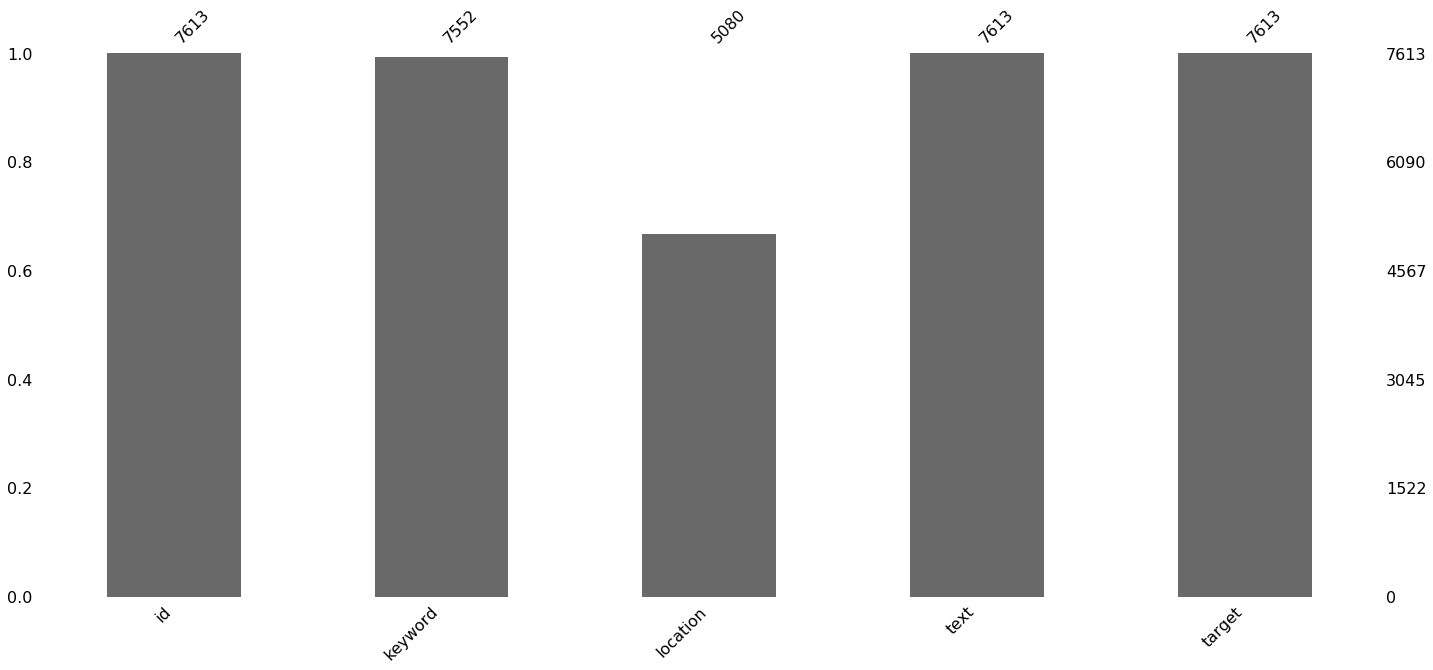

In [6]:
msno.bar(data)

We're only missing data in the keyword and location column. Keyword is missing just a few, while location has around 1/3 missing.

## Data Exploration

Let's explore some details of the data.

### Location
Let's check out the locations, are they well defined?

In [14]:
print("Top")
print(data.location.value_counts().head(20))
print("\n\nBottom")
print(data.location.value_counts().tail(20))

Top
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
California          17
California, USA     15
New York, NY        15
Everywhere          15
United Kingdom      14
Name: location, dtype: int64


Bottom
Viterbo BFA Acting '18           1
Pig Symbol, Alabama              1
Gainesville/Tampa, FL            1
livin life in the 610            1
Kaneohe                          1
Lima, Peru                       1
DC Metro area                    1
[@blackparavde is my frankie]    1
brooklyn, NYC                    1
Ashxjonespr@gmail.com            1
English Midlands                 1
Vista, CA                        1
Bridport, England                1
Norwalk, CT                      1
Providen

Already we can see some weird locations. We have countries (USA, United States, UK), cities (New York, Los Angeles, CA) and random things (Everywhere, livin life in the 610). They're all in different formats.

This might be a decent indicator though. For example, people could be more serious when they're using real locations instead of joke ones. 

We could get list of countries/states/cities and try to match the location. 

There are many locations, but we might also be able to one-hot-encode the top ones. This might be valuable if e.g. US tweets have some common thread.

### Keyword
What sort of keywords are there? How often used?

In [21]:
f'{data.keyword.nunique()} unique keywords'

'221 unique keywords'

In [17]:
data.keyword.value_counts().head(20)

fatalities     45
armageddon     42
deluge         42
body%20bags    41
harm           41
damage         41
sinking        41
twister        40
evacuate       40
outbreak       40
fear           40
windstorm      40
siren          40
collided       40
weapon         39
famine         39
whirlwind      39
collision      39
wreckage       39
flames         39
Name: keyword, dtype: int64

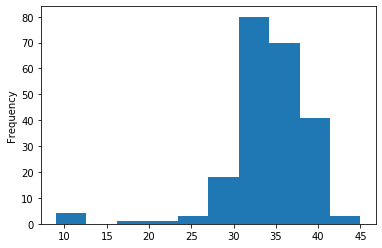

In [18]:
data.keyword.value_counts().plot(kind='hist')

So definitely all these keywords represent bad things, and we can see that there are 221 keywords, mostly with 30-40 occurrences.

How closely do the keywords match the text? Let's check if it's in there!

In [66]:
data.apply(lambda x: str(x.keyword).lower() in str(x.text).lower(), axis=1).value_counts()

True     5973
False    1640
dtype: int64

We see that 80% of the time the keyword is in the text, but still 20% isn't. Where do they get it from then? Let's see some of the examples.

In [69]:
data['keyword_match'] = data.apply(lambda x: str(x.keyword).lower() in str(x.text).lower(), axis=1)
data[data.keyword.notnull()] \
    .query('keyword_match == False') \
    .filter(['keyword', 'text']).head()

,keyword,text
32,ablaze,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
45,ablaze,I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6
48,ablaze,Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
49,ablaze,First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.


Definitely these don't seem to be "ablaze", but we can see that most have a URL. Maybe the tagging is coming from the linked URL.

e.g. for index 45, the linked site is "crowdfire" https://www.crowdfireapp.com/?utm_source=weekly%20stats&utm_medium=tweet&utm_campaign=automated%20tasks

This is related to fire, and hence could have been sorted this way.

Index 49 doesn't seem to have anything to do with fire though. This could make it tough to fully rely on the keywords, but at least 80% match the keyword.

### Language

Are all the tweets in English? Or are their other languages?

In [74]:
data.text.apply(ld.detect).value_counts().head()

en    7304
de      61
da      24
ca      22
fr      19
Name: text, dtype: int64

Seems the majority is in English, around 95%, but there are other languages that we may need to consider. We can start be generating a feature that determines the language.

For the best outcome, we might want to run foreign texts through a translator before processing further.

### Class Sizes
How many of each class do we have?

In [73]:
data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

We almost have a 50/50 split between classes, which is great and means we should be able to train well.

### Dates

If there are dates in the data, these could likely be correlated with actual real world events. This would be a leaky feature that could be utilised.

Let's check if we can find any.

In [86]:
data[data.text.apply(lambda x: '2019' in x)]

,id,keyword,location,text,target,keyword_match
722,1043,bleeding,"Baltimore, MD",@DarrylB1979 yea heard about that..not coming out until 2017 and 2019 ?????? Vampiro is bleeding,0,True


### Text

The text is the main part of the tweet, probably the most reliable indicator.

It can contain URLs. How many? Is there a way to know where they go?

In [89]:
# Always has t.co
data['has_url'] = data.text.apply(lambda x: x.count('t.co'))
data.has_url.value_counts()

0    3643
1    3250
2     696
3      21
4       3
Name: has_url, dtype: int64